## Import

In [1]:
from wmb import brain, cemba, mm10
import seaborn as sns

from ALLCools.clustering import *
from ALLCools.mcds import MCDS
from ALLCools.plot import *

import pandas as pd
import matplotlib.pyplot as plt
from ALLCools.clustering import cluster_enriched_features, log_scale

In [2]:
var_dim = 'geneslop2k'
cluster_col = 'L1'
chrom_to_remove = ['chrX', 'chrY', 'chrM', 'chrL']
downsample = 500

## Select cells

In [3]:
cells = pd.read_csv('mc_cells.txt', index_col=0, header=None).index
cells.name = 'cell'
cells.size

5000

## Downsample cells

In [4]:
annot = cemba.get_mc_annot()
clusters = annot[cluster_col].to_pandas()
clusters = clusters.loc[cells].copy()

if downsample is not None:
    use_cells = []
    for cluster, sub_series in clusters.groupby(clusters):
        if sub_series.size > downsample:
            _cells = sub_series.sample(downsample, random_state=0).index
        else:
            _cells = sub_series.index
        use_cells += _cells.tolist()
    use_cells = pd.Index(use_cells)
else:
    use_cells = cells
    
use_cells.size

4287

## Get adata

In [5]:
mcds = MCDS.open(cemba.CEMBA_SNMC_MCDS_PATH, var_dim=var_dim, use_obs=use_cells)

mcds

<xarray.MCDS>
Dimensions:              (cell: 4287, count_type: 2, geneslop2k: 55487,
                          mc_type: 2)
Coordinates:
  * cell                 (cell) <U15 '10B_M_1879' '10B_M_955' ... '12E_M_1053'
  * count_type           (count_type) <U3 'mc' 'cov'
  * geneslop2k           (geneslop2k) <U21 'ENSMUSG00000102693.1' ... 'ENSMUS...
    geneslop2k_chrom     (geneslop2k) <U5 'chr1' 'chr1' 'chr1' ... 'chrM' 'chrM'
    geneslop2k_cov_mean  (geneslop2k) float64 66.47 52.7 ... 166.3 164.1
    geneslop2k_end       (geneslop2k) int64 3076321 3104124 ... 16299 16299
    geneslop2k_start     (geneslop2k) int64 3071252 3100015 ... 13288 13355
  * mc_type              (mc_type) <U3 'CHN' 'CGN'
Data variables:
    geneslop2k_da        (cell, geneslop2k, mc_type, count_type) uint16 dask.array<chunksize=(1000, 55487, 1, 1), meta=np.ndarray>
    geneslop2k_da_frac   (cell, geneslop2k, mc_type) float32 dask.array<chunksize=(1000, 55487, 1), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  geneslop2k

In [6]:
adata = mcds.get_adata(mc_type=mc_type,
                       select_hvf=False,
                       split_large_chunks=False)

In [7]:
adata.obs[cluster_col] = annot[cluster_col].to_pandas()

## Basic Feature Filtering

In [8]:
remove_chromosomes(adata, exclude_chromosomes=chrom_to_remove)

51259 regions remained.


In [9]:
remove_black_list_region(adata, black_list_path=mm10.ENCODE_BLACKLIST_PATH)

2822 features removed due to overlapping (bedtools intersect -f 0.2) with black list regions.


In [10]:
# remove low std features
pass_std_filter = adata.X.std(axis=0) > 0.05
adata._inplace_subset_var(pass_std_filter)

## CEF Feature Filtering

Found 52 clusters to compute feature enrichment score
Computing enrichment score
Computing enrichment score FDR-corrected P values
Selected 3978 unique features


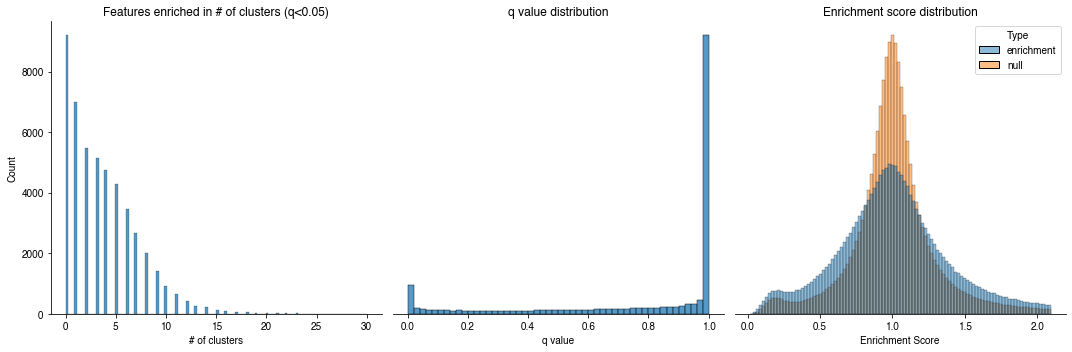

In [11]:
# CEF function take the original mC fraction as input
cluster_enriched_features(adata,
                          cluster_col=cluster_col,
                          top_n=200,
                          alpha=0.05,
                          stat_plot=True,
                          method='mc')

In [12]:
# select CEF only
adata.var[f'{cluster_col}_enriched_features'].to_csv('CEF.csv', header=None)